In [1]:
%%capture
!pip install Biopython
!rm -r iFeature
!git clone https://github.com/Superzchen/iFeature
!git clone https://github.com/FranceCosta/virulent_factor_classification.git

import numpy
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

### Following [this](https://doi.org/10.1093/bib/bbv082) on dataset preparation a treshold of 60% identity have been chosen for a clustering with [CD-hit](http://weizhong-lab.ucsd.edu/cdhit-web-server/cgi-bin/index.cgi?cmd=cd-hit) 

In [2]:
# parse CD-Hit data
infile = open('virulent_factor_classification/new_datasets_cleaned/pos_fasta_60', 'r').readlines()
pos_ids = []
for element in str(infile).split('>'):
    for seq in element.split('\n'):
        if '*' in seq:
            pos_ids.append(seq.split('|')[0][:-3])
infile = open('virulent_factor_classification/new_datasets_cleaned/neg_fasta_60', 'r').readlines()
neg_ids = []
for element in str(infile).split('>'):
    for seq in element.split('\n'):
        if '*' in seq:
            neg_ids.append(seq.split('|')[1])

In [3]:
print(len(neg_ids))
print(len(pos_ids))

limit = min(len(neg_ids), len(pos_ids))

3107
3705


In [4]:
# clean sequence data
pos_seqs = list(SeqIO.parse('./virulent_factor_classification/new_datasets/positive/pos.fasta', 'fasta'))
cleaned_pos_seqs = [entry for entry in pos_seqs if str(entry.id.split('(')[0]) in str(pos_ids)]

neg_seqs = list(SeqIO.parse('./virulent_factor_classification/new_datasets/negative/neg.fasta', 'fasta'))
cleaned_neg_seqs = [entry for entry in neg_seqs if str(entry.id.split('|')[1]) in str(neg_ids)]

# match lengths
cleaned_pos_seqs = cleaned_pos_seqs[:limit] 
cleaned_neg_seqs = cleaned_neg_seqs[:limit]
print('len of pos dataset:', len(cleaned_pos_seqs))
print('len of neg dataset:', len(cleaned_neg_seqs))

len of pos dataset: 3107
len of neg dataset: 3107


In [5]:
# rewrite fasta files
def writer(fasta_list, outfile_name):
    outfile = open(outfile_name, 'w')
    for entry in fasta_list:
        outfile.write('>'+str(entry.id)+'\n')
        outfile.write(str(entry.seq)+'\n')

In [6]:
writer(cleaned_pos_seqs, 'cleaned_pos.fasta')
writer(cleaned_neg_seqs, 'cleaned_neg.fasta')

In [7]:
!python iFeature/iFeature.py --file ./cleaned_pos.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition
!python iFeature/iFeature.py --file ./cleaned_pos.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./cleaned_pos.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition
!python iFeature/iFeature.py --file ./cleaned_pos.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition
!python iFeature/iFeature.py --file ./cleaned_pos.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution

print("pos: DONE!")

!python iFeature/iFeature.py --file ./cleaned_neg.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition
!python iFeature/iFeature.py --file ./cleaned_neg.fasta --type DPC --out dpc_cleaned_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./cleaned_neg.fasta --type CTDC --out ctdc_cleaned_neg.out  # composition
!python iFeature/iFeature.py --file ./cleaned_neg.fasta --type CTDT --out ctdt_cleaned_neg.out  # transition
!python iFeature/iFeature.py --file ./cleaned_neg.fasta --type CTDD --out ctdd_cleaned_neg.out  # distribution

print("neg: DONE!")

Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
pos: DONE!
Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
neg: DONE!


In [8]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'cleaned_pos.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'cleaned_neg.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_cleaned_pos"
    else:
        names = "_cleaned_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(numpy.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = numpy.array(datasets[i])
    return datasets

In [9]:
pos_datasets = from_files_to_vectors("./virulent_factor_classification/new_datasets_cleaned/positive/", positive=True)
neg_datasets = from_files_to_vectors("./virulent_factor_classification/new_datasets_cleaned/negative/", positive=False)

In [10]:
y_pos = numpy.array([1. for _ in range(pos_datasets[0].shape[0])])
y_neg = numpy.array([0. for _ in range(neg_datasets[0].shape[0])])

In [11]:
datasets = []
for i in range(len(pos_datasets)):
    datasets.append(
        numpy.concatenate((pos_datasets[i], neg_datasets[i]), axis=0)
    )
y = numpy.concatenate((y_pos, y_neg), axis=0)

In [12]:
numpy.random.seed(42)
c = numpy.random.permutation(numpy.arange(y.shape[0]))
for i in range(len(pos_datasets)):
    datasets[i] = datasets[i][c]
y = y[c]

In [13]:
train_len = int(.5*y.shape[0])
val_len = int(.25*y.shape[0])
print('train len:', train_len)
print('validation len:', val_len)

train len: 3107
validation len: 1553


In [14]:
datasets_train = [el[:train_len] for el in datasets]
y_train = y[:train_len] # shape = (3107,)

datasets_val = [el[train_len:train_len+val_len] for el in datasets]
y_val = y[train_len:train_len+val_len] # shape = (1553,)

datasets_test = [el[train_len+val_len:] for el in datasets]
y_test = y[train_len+val_len:] # shape = (1554,)

In [15]:
class neural_network:
    def __init__(self):
        input_aac = tensorflow.keras.Input(shape=(20,))
        input_dpc = tensorflow.keras.Input(shape=(400,))
        input_ctdc = tensorflow.keras.Input(shape=(39,))
        input_ctdt = tensorflow.keras.Input(shape=(39,))
        input_ctdd = tensorflow.keras.Input(shape=(195,))
        
        aac_dense = tensorflow.keras.layers.Dense(20, activation='sigmoid')(input_aac)
        dpc_dense = tensorflow.keras.layers.Dense(400, activation='sigmoid')(input_dpc)
        ctdc_dense = tensorflow.keras.layers.Dense(39, activation='sigmoid')(input_ctdc)
        ctdt_dense = tensorflow.keras.layers.Dense(39, activation='sigmoid')(input_ctdt)
        ctdd_dense = tensorflow.keras.layers.Dense(195, activation='sigmoid')(input_ctdd)

        concat = tensorflow.keras.layers.Concatenate()([aac_dense, dpc_dense, ctdc_dense, ctdt_dense, ctdd_dense])

        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(concat)
        model = tensorflow.keras.models.Model(inputs=[input_aac, input_dpc, input_ctdc, input_ctdt, input_ctdd], outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [16]:
nn = neural_network()

In [17]:
history = nn.model.fit(
    x=datasets_train, 
    y=y_train,
    batch_size=64,
    epochs=100,
    verbose=0,
    validation_data=(datasets_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=10
)]
)

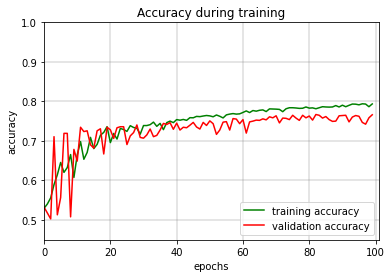

In [23]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

In [19]:
nn.model.evaluate(x=datasets_test, y=y_test)

49/49 [==============================] - 0s 3ms/step - loss: 0.4882 - accuracy: 0.7741


[0.48821863532066345, 0.7741312980651855]

In [20]:
nn.model.save('trained_model.h5')

### Check performace on negative and positive classes

In [21]:
pos_dataset_test = [[] for array in range(len(datasets_test))]
for array in range(len(datasets_test)):
    for item, i in zip(datasets_test[array], y_test):
        if i == 1:
            pos_dataset_test[array].append(list(item))
for i in range(5):
    pos_dataset_test[i]=numpy.array(pos_dataset_test[i])
y_pos_test = numpy.array([1. for _ in range(len(pos_dataset_test[0]))])

neg_dataset_test = [[] for array in range(len(datasets_test))]
for array in range(len(datasets_test)):
    for item, i in zip(datasets_test[array], y_test):
        if i == 0:
            neg_dataset_test[array].append(list(item))
for i in range(5):
    neg_dataset_test[i]=numpy.array(neg_dataset_test[i])
y_neg_test = numpy.array([0. for _ in range(len(neg_dataset_test[0]))])

In [22]:
pos_perf = nn.model.evaluate(x=pos_dataset_test, y=y_pos_test)
neg_perf = nn.model.evaluate(x=neg_dataset_test, y=y_neg_test)
print('Accuracy on POSITIVE classes:', pos_perf[1])
print('Accuracy on NEGATIVE classes:', neg_perf[1])

# conclusion: the model is worst at recognizing virulence factors rather than proteins that are not

25/25 [==============================] - 0s 3ms/step - loss: 0.4068 - accuracy: 0.8480
Accuracy on POSITIVE classes: 0.6965699195861816
Accuracy on NEGATIVE classes: 0.8479899764060974
